# Motivation

In this Notebook, the stratification derived using the reward network is explored. The reward network is generated from the non-tumour dataset, using 5K genes, 3 edges per gene and 6 per TF. 

In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
import os
import sys
import igraph as ig
import pickle

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

import multiprocess as mp

SCRIPT_DIR = os.path.dirname(os.path.abspath("pcgna_processing.py"))
sys.path.append(os.path.dirname(SCRIPT_DIR))
sys.path.append('/Users/vlad/Documents/Code/York/iNet_v2/src/')

from NetworkAnalysis.ExperimentSet import ExperimentSet
from NetworkAnalysis.NetworkComp import NetworkComp
from NetworkAnalysis import GraphHelper as gh
from NetworkAnalysis.utilities import sankey_consensus_plot as sky
from NetworkAnalysis.utilities.helpers import save_fig
from NetworkAnalysis.utilities.helpers import save_fig, survival_plot, survival_comp
from NetworkAnalysis.GraphToolExp import GraphToolExperiment as GtExp
import NetworkAnalysis.utilities.clustering as cs

from NetworkAnalysis.dea import dea
from NetworkAnalysis.dea import helpers as dea_hp
from NetworkAnalysis.dea import gsea as gsea_hp

# Gsea libraries
import gseapy as gp
import matplotlib.pyplot as plt

import graph_tool.all as gt

# %matplotlib inline

pio.templates.default = "ggplot2"


pool = mp.Pool(mp.cpu_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results_path = "../../results/exp/"
data_base = "../../data/"
base_path = "../../results/network_II/"

figures_path = "../network_II/reward/"

# base_sbm_path = "../../../iNet_v2/"
sbm_exps_path = "sbm/"

vu_output = pd.read_csv(f"{data_base}/metadata/VU_clustering_v3.tsv", sep="\t", index_col="Sample")

tcga_mutations_df = pd.read_csv(f"{data_base}/tumour/mutations_tcga.csv")
tcga_mutations_df = tcga_mutations_df[tcga_mutations_df["count"] != 0].set_index("gene")

all_tum_tpms = pd.read_csv(f"{data_base}/tumour/tum_TPMs_selected_genes_gc42_all_v4.tsv", sep="\t", index_col="genes")


healthy_metadata = pd.read_csv(f"{data_base}/metadata/healthy_bladder_metadata.tsv", sep="\t", index_col="Sample", dtype_backend="pyarrow")

# tf list
tf_path = f"{data_base}/metadata/TF_names_v_1.01.txt"
if os.path.exists(tf_path):
    tf_list = np.genfromtxt(fname=tf_path, delimiter="\t", skip_header=1, dtype="str")

# Load experiments

In [3]:
hsbm_v3 = ExperimentSet("v3", base_path=base_path, exp_path=sbm_exps_path, mut_df=tcga_mutations_df, sel_sets=None, exp_type="iNet")

exps = {}
for idx, exp in enumerate(hsbm_v3.get_exps()):
    if exp.sbm_method != "hsbm":  # or idx != 2:
        continue

    print(f"Loading Graph-Tool for {exp.type}")
    exp = GtExp.from_pgcna_inet(exp, rel_path="")

    # partitions from hSBM
    exp.hsbm_add_vp(mut_df=tcga_mutations_df)
    com_df, _ = exp.hsbm_get_gt_df()

    exp.export_to_gephi(save=False, com_df=com_df)

    # Need it for comparison
    exps[exp.type] = exp

hsbm_v3.exps = exps

##### Experiment labels:  dict_keys(['standard_5K_6TF_sbm', 'standard_5K_6TF_hsbm', 'sigmoid_5K_6TF_hsbm'])
Loading Graph-Tool for standard_5K_6TF_hsbm
Loading Graph-Tool for sigmoid_5K_6TF_hsbm


In [4]:
%autoreload 2
sel_gt: GtExp = hsbm_v3.exps["sigmoid_5K_6TF_hsbm"]
gt_state: gt.NestedBlockState = sel_gt.hstateObj["state"]

sel_gt.hsbm_add_vp(mut_df=tcga_mutations_df)

gt_g = sel_gt.gt_g
pv = sel_gt.hstateObj["pv"]
pmode = sel_gt.hstateObj["pmode"]

com_df, _ = sel_gt.hsbm_get_gt_df()
com_df["max_b"] = com_df["P_lvl_0"]

gt.remove_self_loops(gt_g)

######## ModCon and MEVS ########
sel_gt.gt_modCon_MEV(all_tpms=sel_gt.tpm_df)

# Compute and store the nodes/edges with all the information
sel_gt.export_to_gephi(save=False, com_df = com_df)
sel_gt.add_gt_prop_draw(gt_g, com_df=com_df, tf_list=tf_list)
graph_stats = sel_gt.compute_graph_stats()

nodes_df: pd.DataFrame = gh.add_stats_to(nodes_df=sel_gt.nodes_df, tpm_df=sel_gt.tpm_df)

In [5]:
if 0:
    nodes_df[["max_b", "ModCon_Rank", "mean", "median", "std", "var", "count", "ctrl_tf"]].to_csv(figures_path + "nodes_df_hsbm.tsv", sep="\t")
    # sel_gt.export_to_gephi(save=True, com_df=com_df[["max_b", "node_idx"]])

# Analysis

## Most connected genes

In [6]:
network_stats: pd.DataFrame = sel_gt.compute_graph_stats()
network_stats["max_b"] = nodes_df["max_b"].astype(str)
network_stats["Modularity Class"] = nodes_df["Modularity Class"].astype(str)

# network_stats.sort_values(by=[col], ascending=False).to_csv(f"{figures_path}/sigmoid_net_stats.tsv", sep="\t")

col = "degree_t"
top_sel = network_stats.sort_values(by=[col], ascending=False).iloc[:120]
px.bar(top_sel.reset_index(names="gene"), x="gene", y=col, color="max_b", text_auto=True)

In [7]:
net_stats = []
col = "degree_t"
for com in network_stats["max_b"].unique():
    sel_net = network_stats.loc[network_stats["max_b"] == com]
    net_stats.append((com, sel_net[col].mean()))
net_stats = pd.DataFrame(net_stats, columns=["com", "mean_degree"])

net_stats["mean_degree"] = round(net_stats["mean_degree"])
net_stats.sort_values(by="mean_degree", ascending=False, inplace=True)
# px.bar(net_stats, y="mean_degree", x="com", text_auto=True, title="Mean degree across comunities")

In [8]:
nodes_df[nodes_df.index.str.contains("CYP1A1")]

,Label,Gene,Modularity Class,count,TF,b_0,b_1,b_2,b_3,b_4,...,P_lvl_3,P_lvl_4,P_lvl_5,max_b,ModCon_Rank,ctrl_tf,mean,median,std,var
CYP1A1,CYP1A1,CYP1A1,5,2.0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,19,56,0,26.3523,5.796,147.7165,21820.1693


## Most connected genes

### Degree vs Com size

In [9]:
# Community sizes
dmy_df = nodes_df.copy(deep=True)
com_det = "Modularity Class"
com_det = "max_b"
dmy_df.sort_values(by=com_det, inplace=True)
dmy_df[com_det] = dmy_df[com_det].astype(str)

value_counts = dmy_df["max_b"].value_counts()
dmy_df["max_b"] = pd.Categorical(dmy_df["max_b"], categories=value_counts.index, ordered=True)
fig1 = px.histogram(dmy_df, x=com_det, text_auto=True, title="Comunity sizes")

# Mean degree
net_stats, col = [], "degree_t"

for com in network_stats[com_det].unique():
    sel_net = network_stats.loc[network_stats[com_det] == com]
    net_stats.append((int(com), sel_net[col].mean()))
net_stats = pd.DataFrame(net_stats, columns=["com", "mean_degree"])

net_stats["mean_degree"] = round(net_stats["mean_degree"])
net_stats.sort_values(by="com", inplace=True)
net_stats["com"] = net_stats["com"].astype(str)
fig2 = px.bar(
    net_stats, y="mean_degree", x="com", text_auto=True, title="Mean degree across comunities", color_discrete_sequence=[px.colors.qualitative.G10[0]]
)
category_order = net_stats["mean_degree"].sort_values(ascending=False).index.astype(str)
fig2 = fig2.update_xaxes(
    categoryorder="array",
    categoryarray=category_order,
)


# Combined the two figures in subplots
subplots_config = {
    "num_cols": 1,
    "shared_x": False,
    "shared_y": False,
    "h_spacing": 0.05,
    "v_spacing": 0.15,
    "main_title": "Community sizes vs Mean degree",
    "height": 700,
    "width": None,
    "y_title": "Count",
    "x_title": "Community",
    "specs": None,
}
figs = [fig1, fig2]
titles = [
    "",
    "",
]
fig = gh.helper_multiplots(figs, titles, subplots_config)


fig = fig.update_layout(
    title="",
    font=dict(size=20),
)
save_fig(name="Degree_vs_ComSize", fig=fig, base_path=figures_path, width=1400, height=700, margin=0.02)
# fig.show

### Genes in high connected communities

In [10]:
max_dg = net_stats["mean_degree"].max()
# th degree of the given percentile (70) so that it includes all the communities w/ mean degree > 10
th = 70
th_dg = np.percentile(net_stats["mean_degree"], 70)
coms = net_stats[net_stats["mean_degree"] > th_dg]["com"].astype(int)
print(f"Number of coms {coms.shape[0]} of {len(nodes_df['max_b'].unique())}")
print(list(coms.values))

sel_com_genes = nodes_df.loc[nodes_df["max_b"].isin(coms)][["count", "TF", "max_b"]].rename(columns={"count": "mut_count"})
print(f"Nummber of genes selected {sel_com_genes.shape[0]}")

Number of coms 14 of 45
[1, 2, 3, 5, 7, 8, 10, 12, 15, 18, 28, 32, 33, 42]
Nummber of genes selected 122


In [79]:
col = "degree_t"
sel_com_genes["degree_t"] = network_stats["degree_t"]
sel_com_genes.sort_values(by="degree_t", ascending=False, inplace=True)
sel_com_genes["max_b"] = sel_com_genes["max_b"].astype(str)
colors = px.colors.qualitative.Pastel + px.colors.qualitative.Safe
fig = px.bar(sel_com_genes.reset_index(names="gene"), x="gene", y=col, color="max_b", color_discrete_sequence=colors)
fig = fig.update_layout(
    title="",
    legend=dict(
        title="Community",
        orientation="h",
        yanchor="middle",
        xanchor="center",
        y=0.90,
        x=0.5,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=18, color="#003366"),
    ),
    yaxis=dict(tickfont=dict(size=20), title="Degree"),
    xaxis=dict(tickfont=dict(size=20), title="Gene"),
    font=dict(size=20),
    height=600,
)

# fig.update_layout(
#     xaxis=dict(tickmode="linear", tick0=0, dtick=1),
# )

save_fig(name="SmallCom_gene", fig=fig, base_path=figures_path, width=1300, height=600, margin=0.02)
fig

### Mutation

Are those genes the highest mutated?

In [115]:
dmy_df = sel_gt.nodes_df.copy(deep=True)
dmy_df["Type"] = "Rest"
dmy_df.loc[sel_com_genes.index, "Type"] = "High Degree"

fig = px.histogram(dmy_df, x="count", color="Type", log_y=True, barmode="overlay")
fig = fig.update_layout(
    title="",
    legend=dict(
        title="Type",
        orientation="h",
        yanchor="middle",
        xanchor="center",
        y=0.90,
        x=0.5,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=18, color="#003366"),
    ),
    yaxis=dict(tickfont=dict(size=20), title="Log Count"),
    xaxis=dict(tickfont=dict(size=20), title="Mutation Burden"),
    font=dict(size=20),
)
save_fig(name="smallCom_MutHist", fig=fig, base_path=figures_path, width=1600, height=500, margin=0.02)
fig

In [114]:
sel_com_genes["mean"] = sel_gt.nodes_df["mean"]
sel_com_genes["std"] = sel_gt.nodes_df["std"]
sel_com_genes["mut_count"] = sel_gt.nodes_df["count"]

fig = px.bar(sel_com_genes, y="mean", color="max_b", log_y=True, color_discrete_sequence=colors, error_y="std")

fig = fig.update_layout(
    title="",
    legend=dict(
        title="Community",
        orientation="h",
        yanchor="middle",
        xanchor="center",
        y=0.95,
        x=0.5,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=18, color="#003366"),
    ),
    yaxis=dict(tickfont=dict(size=20), title="Log Mean TPM"),
    xaxis=dict(tickfont=dict(size=20), title="Gene"),
    font=dict(size=20),
    height=600,
)

# fig.update_layout(
#     xaxis=dict(tickmode="linear", tick0=0, dtick=1),
# )
save_fig(name="smallCom_Exp", fig=fig, base_path=figures_path, width=1700, height=700, margin=0.02)
fig

In [126]:
sel_com_genes[sel_com_genes["std"] >= sel_com_genes["mean"]].shape

(17, 6)

In [ ]:
sel_com_genes[sel_com_genes["max_b"] == "7"]

### Corr and summary figure

THe plot at the end is very similar to the bar plot at the start of this section but I think it is more of an overview, showing the relation between com size and mean_degree

In [13]:
from scipy import stats

# Compute the mutation burden per community
mut_mean = []
for com in dmy_df["max_b"].unique():
    tst = round(dmy_df[dmy_df["max_b"] == com]["count"].mean(), 3)
    mut_mean.append((com, tst))
tst = pd.DataFrame(mut_mean, columns=["Com", "Mutation Mean"]).set_index("Com")

tst_df = pd.concat([net_stats.set_index("com"), dmy_df["max_b"].value_counts().rename("size"), tst], axis=1).reset_index(names="com")
tst_df["com"] = tst_df["com"].astype(int)
tst_df["type"] = "LowDegree"
tst_df.loc[tst_df["com"].isin(coms), "type"] = "HighDegree"

# Show the text only for communities that have a size > 190 and mean_degree > 50
show_com = list(tst_df[(tst_df["size"] > 191) | (tst_df["mean_degree"] > 40)].index)
tst_df["text"] = tst_df["com"]
tst_df.loc[~tst_df["com"].isin(show_com), "text"] = ""

from scipy import stats

spr = stats.spearmanr(tst_df["mean_degree"], tst_df["size"])
print(f"Degree vs Size: Spearman of {spr.statistic:.4} with p={spr.pvalue:.2e}")

spr = stats.spearmanr(tst_df["mean_degree"], tst_df["Mutation Mean"])
print(f"Degree vs Mutation: Spearman of {spr.statistic:.4} with p={spr.pvalue:.2e}")

Degree vs Size: Spearman of -0.8987 with p=5.46e-17
Degree vs Mutation: Spearman of 0.8039 with p=2.94e-11


In [14]:
##### Plotting
fig = px.scatter(tst_df, x="mean_degree", y="size", color="type", size="Mutation Mean", text="text", title="Mean Degree vs Community Size")
fig.update_traces(textposition="top center")
fig.add_annotation(x=195, y=600, text="Size vs (avg) Degree  ⍴=-0.8987 with p=5.46e-17", showarrow=False, font=dict(size=18, color="#003366"))
fig.add_annotation(x=195, y=540, text="Size vs (avg) Mutation ⍴=0.8039 with p=2.94e-11", showarrow=False, font=dict(size=18, color="#003366"))

fig = fig.update_layout(
    title="",
    legend=dict(
        title="Type",
        orientation="h",
        yanchor="middle",
        xanchor="center",
        y=0.90,
        x=0.5,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=18, color="#003366"),
    ),
    xaxis=dict(tickfont=dict(size=20), title="Mean Degree"),
    yaxis=dict(tickfont=dict(size=20), title="Community Size"),
    font=dict(size=20),
    height=600,
)
save_fig(name="LargeSmall_com", fig=fig, base_path=figures_path, width=1300, height=600, margin=0.02)
fig.update_layout(height=700)

## Community detection comparison

In [15]:
reorder_cols = [
    "Modularity Class",
    "max_b",
]
meta, sky_fig = sky.main(df=nodes_df, reorder_cols=reorder_cols, title="Modularity maximisation vs hSBM", retMeta=True)
sky_fig.update_layout(height=700)

# Morpheus

## All communities

In [353]:
# Select the experiment
sel_gt: GtExp = hsbm_v3.exps["sigmoid_5K_6TF_hsbm"]

##### Sample to remove from observations
# v3.1 removing when cut is set to 11 in norm
samples_to_remove = ["TCGA-UY-A9PA", "TCGA-FD-A3SR", "TCGA-GV-A3QH", "TCGA-G2-A2EF", "TCGA-GV-A3QI"]
# v3.2 removing when cut is set to 19 norm
samples_to_remove.extend(["TCGA-E7-A6MF", "TCGA-FJ-A3Z7", "TCGA-E7-A677"])
# v3.3 removing at cut 17
samples_to_remove.extend(["TCGA-5N-A9KI", "TCGA-E7-A541", "TCGA-GV-A3JX"])

samples_to_remove = []

# pre-processing
df = all_tum_tpms.drop(columns=samples_to_remove)

# Run ModCon and MEVs and then find the clusters
label = "rwd_all"
sel_gt.gt_modCon_MEV(all_tpms=df, is_imev=True, com_df=com_df)
allComs_cs, figs, metrics = gh.run_clusters(sel_gt, label=label, show_figs=True)
# figs.update_layout(height=900)
allComs_metrics = gh.rank_cs_metrics(metrics, label=label)

Variation per principal component [0.55064402 0.26745057] and the sum 81.81%


In [354]:
settings = {
    "cs_num_1": 5,
    "cs_num_2": 7,
    "sel_mut": pd.DataFrame(),
    "vu_output": vu_output,
    "cs_exp": allComs_cs,
    "figures_path": f"{figures_path}/Morpheus/allComs/",
    "label_col_cs": label,
    "filename": f"allComs_{sel_gt.type}_iMev_3.0",
}

allComs_morph = sel_gt.export_morpheus(settings)

### Import the Morpheus result

This is from using hierarchical clustering with Average linkage and cosine distance

In [356]:
morpheus_path = f"{figures_path}/Morpheus/allComs/"
if 0:

    morp_df = pd.read_csv(f"{morpheus_path}/norm_allComs_sigmoid_5K_6TF_hsbm_iMev_3.0.gct", sep="\t", skiprows=2)

    columns = morp_df["id"]
    morp_df = morp_df.transpose()
    morp_df.columns = columns
    morp_df = morp_df.iloc[2:, :]

    morp_df.rename_axis("sample", axis="columns", inplace=True)

    # morp_df["dendrogram_label"] = morp_df["dendrogram_cut"].replace({3: "mes-like", 4: "large-basal", 5: "small-basal", 13: "large-luminal", 12: "lum-inf"})

    keep_clusters = []
    # Size of 1%
    size_th = round(morp_df.shape[0] * 0.01)
    for cluster, size in morp_df["dendrogram_cut"].value_counts().items():
        if size > 5:
            keep_clusters.append(cluster)

    # Drop clusters that are smaller than 1% of the cohort size
    morp_df = morp_df.loc[morp_df["dendrogram_cut"].isin(keep_clusters)]

    reorder_cols = [
        "TCGA408_classifier",
        # "KMeans_labels_6",
        # "dendrogram_cut",
        "RawKMeans_CS_7_rwd_all",
        "2019_consensus_classifier",
    ]
    meta, sky_fig = sky.main(df=morp_df, reorder_cols=reorder_cols, title="{}. Comp between {} ".format("SBM derived ", ", ".join(reorder_cols)), retMeta=True)
    sky_fig.show()

## High Degree communities

In [325]:
# from observations
samples_to_remove = []

# pre-processing
df = all_tum_tpms.drop(columns=samples_to_remove)

# Determine the list of high and low deg
highDeg_coms = [int(com) for com in sel_com_genes["max_b"].unique()]
lowDegComs = set(sel_gt.gt_modCon.keys()) - set(highDeg_coms)

# Remove the unwanted comunities
for key in lowDegComs:
    sel_gt.gt_modCon.pop(key, None)

#### Run ModCon and MEVs and then find the clusters
label = "rwd_highDeg"
sel_gt.gt_modCon_MEV(all_tpms=df, is_imev=True, com_df=com_df)
highDeg_cs, figs, metrics = gh.run_clusters(sel_gt, label=label, show_figs=True)
highDeg_metrics = gh.rank_cs_metrics(metrics, label=label)

### Export it
if 0:
    settings = {
        "cs_num_1": 5,
        "cs_num_2": 7,
        "sel_mut": pd.DataFrame(),
        "vu_output": vu_output,
        "cs_exp": highDeg_cs,
        "figures_path": f"{figures_path}/Morpheus/highDeg/",
        "label_col_cs": label,
        "filename": f"highDeg_{sel_gt.type}_iMev_3.0",
    }

highDeg_morph = sel_gt.export_morpheus(settings)

#### Reset ModCon / MECVs
delattr(sel_gt, "gt_modCon")
sel_gt.gt_modCon_MEV(all_tpms=df, is_imev=True, com_df=com_df)

Variation per principal component [0.5943924  0.20823983] and the sum 80.26%


## Low Degree communities


In [322]:
# from observations
samples_to_remove = []

# pre-processing
df = all_tum_tpms.drop(columns=samples_to_remove)

# Determine the list of high and low deg
highDeg_coms = [int(com) for com in sel_com_genes["max_b"].unique()]
lowDegComs = set(sel_gt.gt_modCon.keys()) - set(highDeg_coms)

# Remove the High degree coms so that we keep only the lowDeg
for key in highDeg_coms:
    sel_gt.gt_modCon.pop(key, None)

# Run ModCon and MEVs and then find the clusters
label = "rwd_lowDeg"
sel_gt.gt_modCon_MEV(all_tpms=df, is_imev=True, com_df=com_df)
lowDeg_cs, figs, metrics = gh.run_clusters(sel_gt, label=label, show_figs=True)
lowDeg_metrics = gh.rank_cs_metrics(metrics, label=label)

### Export it
if 0:
    settings = {
        "cs_num_1": 5,
        "cs_num_2": 7,
        "sel_mut": pd.DataFrame(),
        "vu_output": vu_output,
        "cs_exp": lowDeg_cs,
        "figures_path": f"{figures_path}/Morpheus/lowDeg/",
        "label_col_cs": label,
        "filename": f"lowDeg_{sel_gt.type}_iMev_3.0",
    }

    lowDeg_morph = sel_gt.export_morpheus(settings)

#### Reset ModCon/MEV
delattr(sel_gt, "gt_modCon")
sel_gt.gt_modCon_MEV(all_tpms=df, is_imev=True, com_df=com_df)

Variation per principal component [0.55262471 0.26747786] and the sum 82.01%


In [324]:
pd.concat([allComs_metrics, highDeg_metrics, lowDeg_metrics], axis=1)

,rwd_all,rwd_highDeg,rwd_lowDeg
Sil_cos_1,Avg_5,KM_4,Avg_4
Sil_cos_2,Avg_6,GaussianMixture_4,Avg_5
Sil_cos_3,Avg_4,Avg_4,Avg_6
Cal_hab_1,KM_4,KM_4,KM_4
Cal_hab_2,GaussianMixture_4,Spec_4,GaussianMixture_4
Cal_hab_3,Spec_4,KM_5,Spec_4
Dav_bou_1,Avg_9,Avg_9,Avg_7
Dav_bou_2,Spec_4,Avg_8,Avg_6
Dav_bou_3,Avg_8,KM_4,Avg_5


## Cluster comparison across all three

In [352]:
comb_df = pd.concat([vu_output, allComs_cs, highDeg_cs.drop(columns=["PC_1", "PC_2"]), lowDeg_cs.drop(columns=["PC_1", "PC_2"])], axis=1).dropna()
K = 6
model = "RawKMeans"  # Avg, Birch, GaussianMixture
reorder_cols = [
    # "TCGA408_classifier",
    "KMeans_labels_6",
    f"{model}_CS_{K}_rwd_highDeg",
    f"{model}_CS_{K}_rwd_all",
    f"{model}_CS_{K}_rwd_lowDeg",
    "consensus",
]

meta, sky_fig = sky.main(df=comb_df, reorder_cols=reorder_cols, title="Different selection mechanisms", retMeta=True)
sky_fig.show()

## Genes from High Degree Communities

In [ ]:
### Prepare the samples
# v3.1 - removing all dendrogram cut 6 remove all the samples clusterd in <3 groups
samples_to_remove = ["TCGA-DK-AA6T", "TCGA-GV-A3QI", "TCGA-ZF-A9RN", "TCGA-BT-A20J", "TCGA-HQ-A2OF"]

# v3.2
vu_cols = ["KMeans_labels_6", "2019_consensus_classifier", "TCGA408_classifier", "Lund2017.subtype"]
data = all_tum_tpms.loc[sel_com_genes.index].drop(columns=samples_to_remove)
data = np.log2(data + 1)

In [ ]:
#### Export
comb_df = pd.concat([data.T, vu_output[vu_cols]], axis=1).dropna()
comb_df = pd.concat([sel_com_genes["max_b"], comb_df.T], axis=1).T
comb_df = comb_df[list(vu_cols) + list(sel_com_genes.index)]

comb_df.T.to_csv(f"{figures_path}/Morpheus/genes_highDegree/tum_{sel_gt.type}_highDeg_v3.1.tsv", sep="\t")
comb_df.T


if 0:
    # # only the 122 genes
    # data = all_tum_tpms.loc[sel_com_genes.index].drop(columns=samples_to_remove).T

    # #### Runing the clustering
    # label = "highDeg"
    # selected_clusters = ["Birch", "RawKMeans", "GaussianMixture", "Ward", "SpectralClustering", "Avg"]
    # # run experiments
    # outputs, _, all_metrics, _ = cs.compare_exp(
    #     data, rob_comp=None, n_clusters=None, selected_clusters=selected_clusters, show_figures=False, show_consensus=True, pca_data=False
    # )
    # outputs.set_index("Sample", inplace=True)

    # new_cols = [col + "_" + label for col in outputs.columns[2:]]
    # outputs.columns = ["PC_1", "PC_2"] + new_cols

## Analyse MIBC for all communities


In [357]:
# Select the experiment
sel_gt: GtExp = hsbm_v3.exps["sigmoid_5K_6TF_hsbm"]

##### Sample to remove from observations
samples_to_remove = []

# pre-processing
df = all_tum_tpms.drop(columns=samples_to_remove)

# Run ModCon and MEVs and then find the clusters
label = "rwd_all"
sel_gt.gt_modCon_MEV(all_tpms=df, is_imev=True, com_df=com_df)
allComs_cs, figs, metrics = gh.run_clusters(sel_gt, label=label, show_figs=True)
# figs.update_layout(height=900)
allComs_metrics = gh.rank_cs_metrics(metrics, label=label)

Variation per principal component [0.55064402 0.26745057] and the sum 81.81%


# Biology 

## AHR search

In [16]:
ahr_study = pd.read_csv(f"{data_base}/metadata/ahr_study_SB_RS.tsv", sep="\t", index_col="genes", dtype_backend="pyarrow")
ahr_study = ahr_study[ahr_study["Log2FC"] > 0.75]

# filter out the non-sig values
ahr_study = ahr_study[ahr_study["qval"] < 0.05]
ahr_study.sort_values(by="qval")

# Compute the PI values
ahr_study["-log10(q)"] = -np.log10(ahr_study["qval"])
ahr_study["pi"] = ahr_study["-log10(q)"] * ahr_study["Log2FC"]
ahr_study = ahr_study[ahr_study["pi"] != 0]

# Select the genes
all_up_reg_sig = ahr_study.index
top_100 = ahr_study.sort_values(by="pi", ascending=False).index.values[:100]

In [17]:
# ahr_genes = ["HSP90AB1", "AHR", "AIP", "PTGES3", "ARNT", "ARNT2"]
ahr_genes = top_100
ahr_genes = all_up_reg_sig

sel_ahr = nodes_df[nodes_df.index.isin(ahr_genes)]
print(f"Total AHR genes {len(ahr_genes)}. Found in 5K {sel_ahr.shape[0]}. Tum found {all_tum_tpms[all_tum_tpms.index.isin(ahr_genes)].shape[0]}")
# print(f"Found in communities {sel_ahr['max_b'].value_counts()}")
sel_ahr["max_b"] = sel_ahr["max_b"].astype(str)
px.histogram(sel_ahr, x="max_b", text_auto=True)

Total AHR genes 198. Found in 5K 103. Tum found 197


In [18]:
gene = "AHR"
neigbhors = sel_gt.filter_graph(gene=gene)
gt_g.set_vertex_filter(None)
stats_neigbhors = sel_gt.process_neigbhors(v_idxs=neigbhors)

sel_df = nodes_df.loc[nodes_df["node_idx"].isin(neigbhors)]
ahr_sel = sel_df[sel_df.index.isin(ahr_genes)][["max_b", "count", "TF", "mean", "median", "std", "var"]]

ahr_sel["max_b"] = ahr_sel["max_b"].astype(str)
px.histogram(ahr_sel, x="max_b", text_auto=True, title=f"Neigbhors of {gene} and genes in the AHR up-regulated")

AHR. Idx = 3. Comm = 2


In [19]:
# fig = sel_gt.plot_overview_gene(gene_name="COL7A1")
# display(fig.show())
fig = sel_gt.plot_overview_gene(gene_name="AHR")
display(fig.show())

AHR. Idx = 3. Comm = 2


None

In [20]:
sel_ahr = nodes_df.loc[nodes_df["max_b"] == 32][["count", "TF", "max_b", "mean", "std"]]
display(sel_ahr)

print(sel_ahr.index.values)

,count,TF,max_b,mean,std
RNF213,37.0,0,32,66.8596,43.1228
MPDZ,19.0,0,32,19.0647,11.7772
SHROOM3,18.0,0,32,10.6359,7.4220
CDKN2A,28.0,0,32,85.7347,82.7526
HSPG2,27.0,0,32,75.2666,57.4376
PARP14,17.0,0,32,49.2693,35.5738
ZNFX1,15.0,0,32,45.3378,26.0021
EPG5,26.0,0,32,23.0477,14.2305
OAS2,13.0,0,32,98.4521,85.4434
NYNRIN,15.0,0,32,39.9672,22.5634


['RNF213' 'MPDZ' 'SHROOM3' 'CDKN2A' 'HSPG2' 'PARP14' 'ZNFX1' 'EPG5' 'OAS2'
 'NYNRIN']


## PPARG and RARG signatures

In [21]:
fig = sel_gt.plot_overview_gene(gene_name="PPARG")
display(fig.show())

PPARG. Idx = 2030. Comm = 18


None

In [22]:
def plot_rarg_pparg_com_rep(p_r_clas: pd.DataFrame, df: pd.DataFrame, tum_df: pd.DataFrame, nodes_df: pd.DataFrame, prefix_col="", main_title="Title"):

    figs, titles = [], []
    # Iterate over the metrics and plot the histograms
    for col in p_r_clas.columns:

        genes = df[f"{prefix_col}{col}"].dropna().values
        h_sel = nodes_df[nodes_df.index.isin(genes)]

        t_sel = tum_df[tum_df.index.isin(genes)]
        h_sel["max_b"] = h_sel["max_b"]
        h_sel.sort_values(by=["max_b"], inplace=True)
        h_sel["max_b"] = h_sel["max_b"].astype(str)

        # Create a histogram using go.Histogram instead of px.histogram
        trace = go.Histogram(x=h_sel["max_b"], texttemplate="%{y}", autobinx=True, name=col)
        figs.append(trace)  # append the trace instead of the figure
        titles.append(f"{col}. #Genes {len(genes)}, found h {h_sel.shape[0]}, t {t_sel.shape[0]}")

    # Set the number of rows and columns for the subplot
    num_rows = round(len(p_r_clas.columns) / 2)
    num_cols = 2

    # Create a figure and subplots
    fig = make_subplots(
        rows=num_rows, cols=num_cols, subplot_titles=titles, horizontal_spacing=0.05, vertical_spacing=0.2, shared_xaxes=False, shared_yaxes=False
    )

    # Adding each plot into the subplot grid
    for i, trace in enumerate(figs):
        row = (i // num_cols) + 1
        col = (i % num_cols) + 1
        fig.add_trace(trace, row=row, col=col)

    # Manually update the x-axis titles if needed
    for i in range(len(figs)):
        row = (i // num_cols) + 1
        col = (i % num_cols) + 1
        fig.update_xaxes(title_text="max_b", row=row, col=col)

    # Update layout to handle more customization and display
    fig.update_layout(height=700, title_text=main_title)
    fig.show()


p_r_clas = pd.read_csv(f"{data_base}/metadata/nuclear_receptor/pparg_rarg_up_dn_classifier.tsv", sep="\t")
p_r_sig = pd.read_csv(f"{data_base}/metadata//nuclear_receptor/pparg_rarg_up_dn_sig.tsv", sep="\t")

In [23]:
plot_rarg_pparg_com_rep(p_r_clas=p_r_clas, df=p_r_sig, tum_df=all_tum_tpms, nodes_df=nodes_df, prefix_col="genes_", main_title="PPARG/RARG significant genes")

In [24]:
plot_rarg_pparg_com_rep(p_r_clas=p_r_clas, df=p_r_clas, tum_df=all_tum_tpms, nodes_df=nodes_df, prefix_col="", main_title="PPARG/RARG classifier genes")

In [25]:
# Show community sizes
if 0:
    dmy_df = nodes_df.copy(deep=True)
    dmy_df.sort_values(by="max_b", inplace=True)
    dmy_df["max_b"] = dmy_df["max_b"].astype(str)
    px.histogram(dmy_df, x="max_b", text_auto=True, title="Comunity sizes")

### Pre-processing RAPH's list

In [26]:
# pre-processing RAPH's list
if 0:
    excel_file = pd.ExcelFile(f"{data_base}/metadata/nuclear_receptor/PPARG_RARG significant 2 fold.xlsx")

    comb_df = pd.DataFrame()
    for sheet_name in excel_file.sheet_names:
        df = pd.read_excel(excel_file, sheet_name=sheet_name)
        r_cols = {}
        new_name = sheet_name.replace(" sig 2 fold ", "_")
        for col in df.columns:
            r_cols[col] = f"{col}_{new_name}"

        comb_df = pd.concat([comb_df, df.rename(columns=r_cols)], axis=1)

    comb_df.to_csv(f"{data_base}/metadata//nuclear_receptor/pparg_rarg_up_dn_sig.tsv", sep="\t", index=False)

# Std vs Rwd

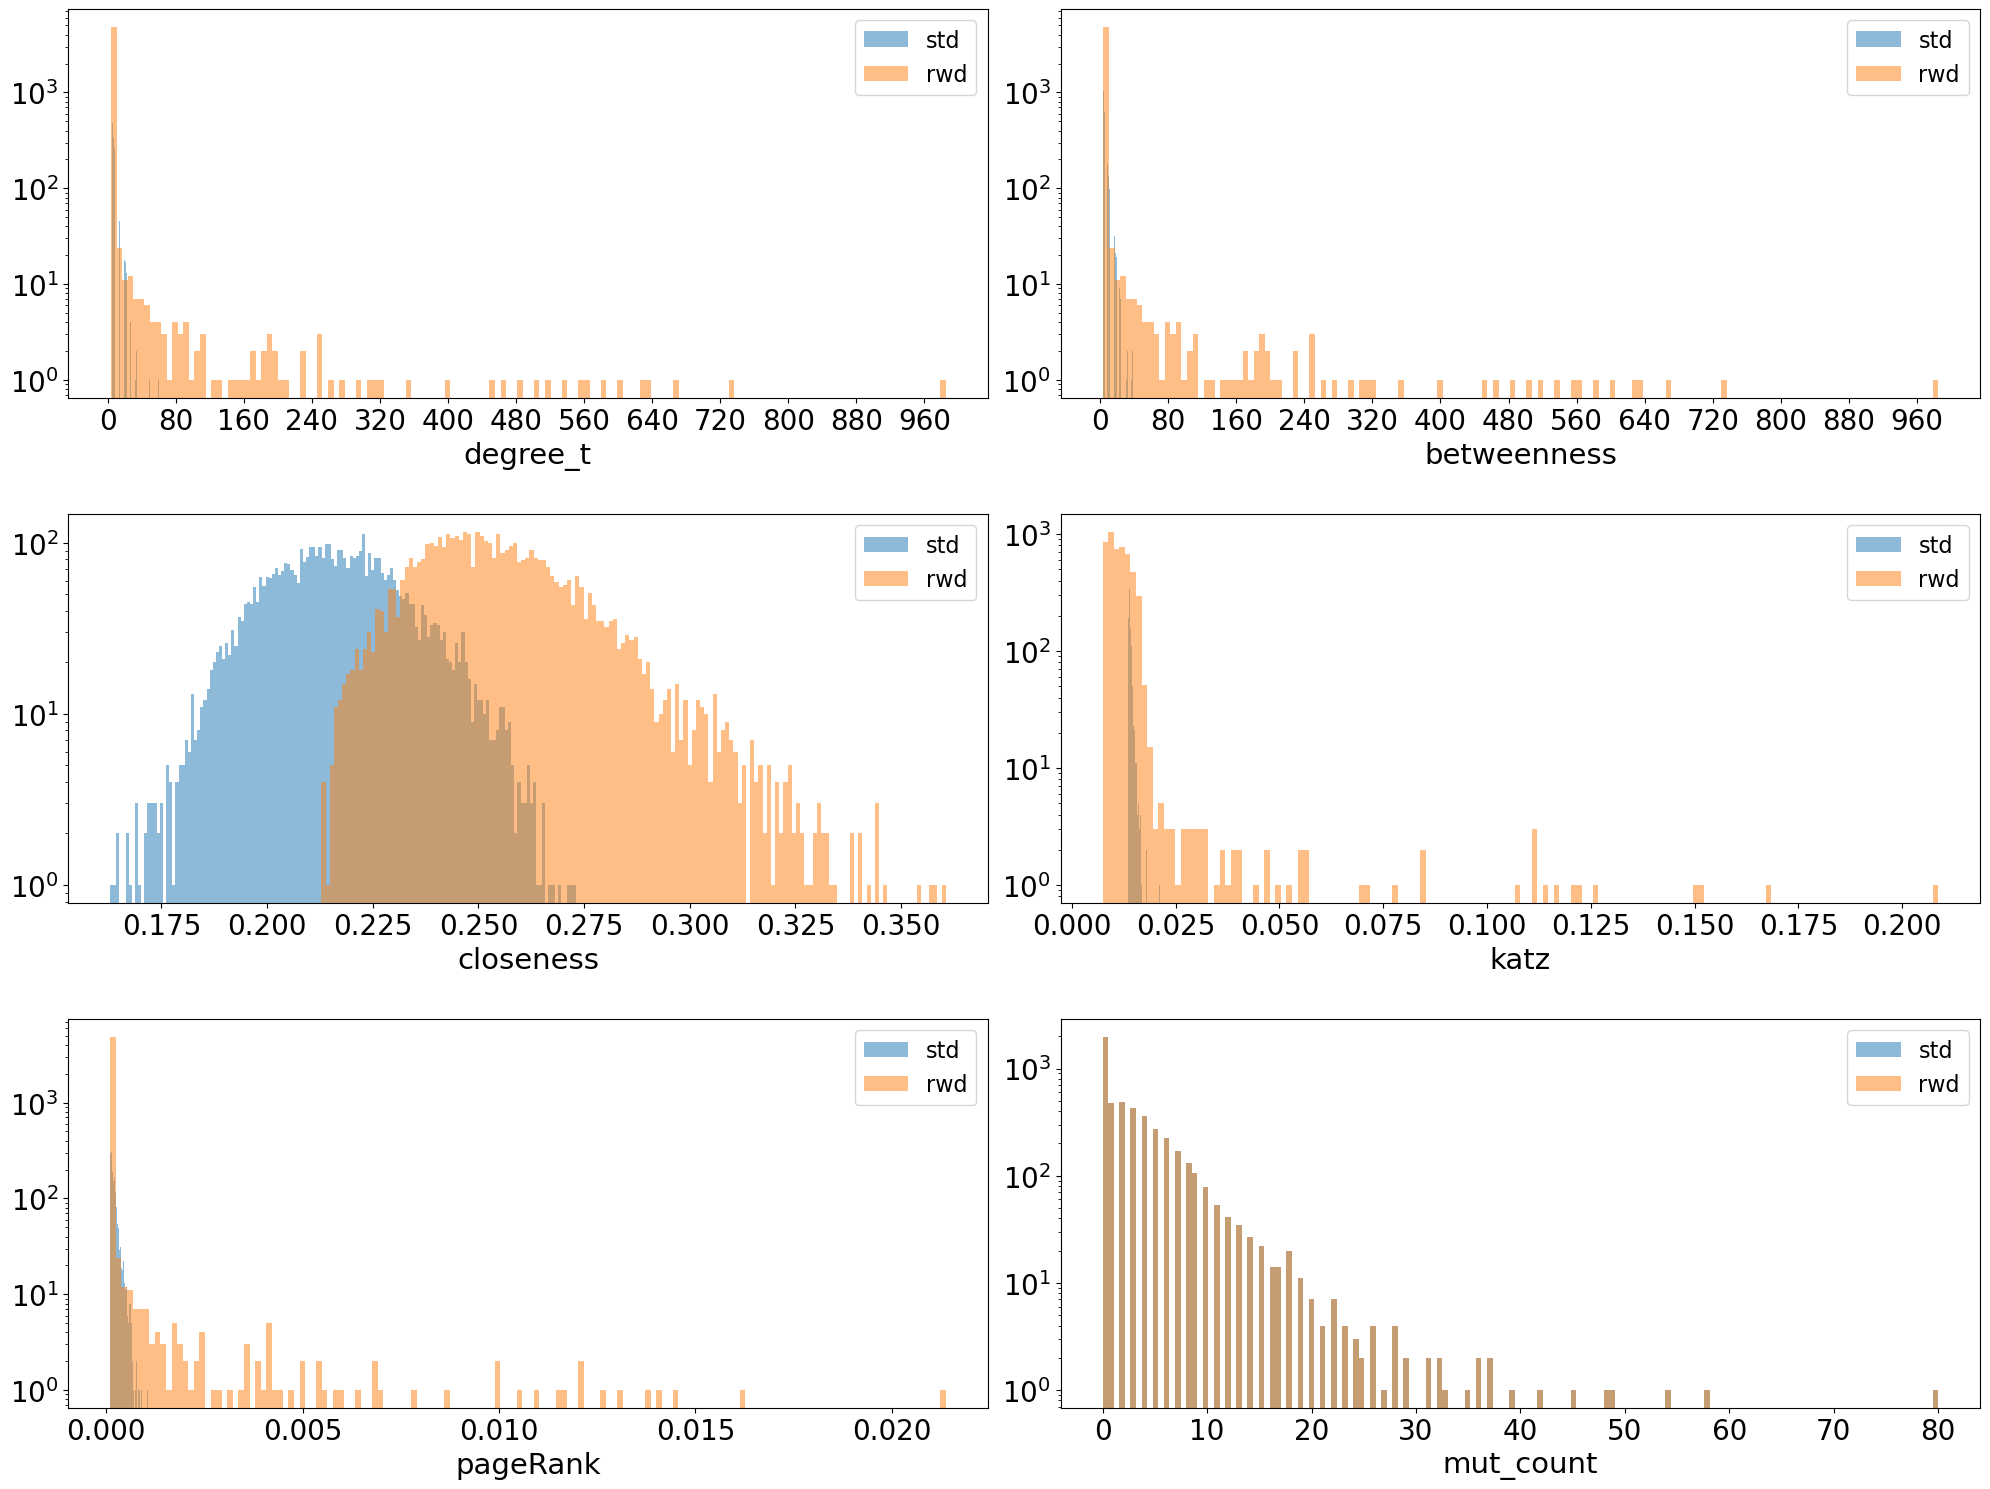

In [27]:
std_exp: GtExp = hsbm_v3.exps["standard_5K_6TF_hsbm"]
rwd_exp: GtExp = hsbm_v3.exps["sigmoid_5K_6TF_hsbm"]

std_com_df, _ = std_exp.hsbm_get_gt_df()
rwd_com_df, _ = rwd_exp.hsbm_get_gt_df()
std_nodes_df: pd.DataFrame = gh.add_stats_to(nodes_df=std_exp.nodes_df, tpm_df=std_exp.tpm_df)
rwd_nodes_df: pd.DataFrame = gh.add_stats_to(nodes_df=rwd_exp.nodes_df, tpm_df=rwd_exp.tpm_df)

comp_std_net: NetworkComp = NetworkComp(hsbm_v3, 5, "standard_5K_6TF_hsbm", "sigmoid_5K_6TF_hsbm", mod_type="sbm")
fig, graph_stats_std, graph_stats_rwd = comp_std_net.plot_network_stats(nodes_df_1=std_nodes_df, nodes_df_2=rwd_nodes_df, label_1="std", label_2="rwd")

In [28]:
#### Standard
print("#### Running Standard")
std_exp.gt_modCon_MEV(all_tpms=all_tum_tpms, is_imev=True, com_df=std_com_df)
std_cs_exp, std_fig, metrics = gh.run_clusters(std_exp, label="std", show_figs=True, norm=False)

label, mevs = "std", std_exp.mevsMut
std_top_metrics = gh.rank_cs_metrics(metrics, label=label)

#### Reward
print("#### Running Rewards")
rwd_exp.gt_modCon_MEV(all_tpms=all_tum_tpms, is_imev=True, com_df=rwd_com_df)
rwd_cs_exp, rwd_fig, metrics = gh.run_clusters(rwd_exp, label="rwd", show_figs=True, norm=False)

label, mevs = "rwd", rwd_exp.mevsMut
rwd_top_metrics = gh.rank_cs_metrics(metrics, label=label)

#### Running Standard
Variation per principal component [0.51105831 0.29528146] and the sum 80.63%
#### Running Rewards
Variation per principal component [0.55064402 0.26745057] and the sum 81.81%


## Clustering comparison

In [29]:
num_1, num_2 = 7, 13
model_1, model_2 = f"RawKMeans_CS_{num_1}", f"RawKMeans_CS_{num_2}"

dmy_all = pd.concat([std_cs_exp[[f"{model_1}_std", f"{model_2}_std"]], rwd_cs_exp[[f"{model_1}_rwd", f"{model_2}_rwd"]]], axis=1).dropna()
dmy_all = pd.concat([dmy_all, vu_output], axis=1).dropna()

reorder_cols = [
    "TCGA408_classifier",
    "KMeans_labels_6",
    f"RawKMeans_CS_{num_1}_std",
    f"RawKMeans_CS_{num_1}_rwd",
    "consensus",
]
meta = sky.main(df=dmy_all, reorder_cols=reorder_cols, title=f'Gene filtering v3 vs v4. Comp between {", ".join(reorder_cols)}', retMeta=False)

## Community comparison

In [30]:
%autoreload 2
# Rename so that are easier to follow. the max_b_standard_5K_6TF_hsbm are also stored in comp_std_net in 'source' property
comp_std_net.comp_df["max_b_standard_5K_6TF_hsbm"] = hsbm_v3.combined_nodes["max_b_standard_5K_6TF_hsbm"].str.replace("standard_5K_6TF_hsbm_", "std")
comp_std_net.comp_df["max_b_sigmoid_5K_6TF_hsbm"] = hsbm_v3.combined_nodes["max_b_sigmoid_5K_6TF_hsbm"].str.replace("sigmoid_5K_6TF_hsbm_", "sig")

comp_dict = comp_std_net.comp_ge_comm()
# for key, df in comp_dict.items():
#     fig = px.box(df, x="Comm", y="Median", color="Comm", title="Median values in communities for {}".format(key), points="all")
#     fig.show()

fig = comp_std_net.sankey_plot()
fig = fig.update_layout(height=1200)

# display(comp_std_net.membership_change(include_source=True))

# hSBM visualisation

In [31]:
sel_gt: GtExp = hsbm_v3.exps["sigmoid_5K_6TF_hsbm"]
gt_g: gt.Graph = sel_gt.gt_g

com_df, _ = sel_gt.hsbm_get_gt_df()
sel_gt.graph_type = "sbm"
sel_gt.nodes_df["node_idx"] = com_df["node_idx"]
sel_gt.nodes_df["max_b"] = com_df["max_b"]

sel_gt.hsbm_add_vp(mut_df=tcga_mutations_df)
sel_gt.add_gt_prop_draw(sel_gt.gt_g, com_df=com_df, tf_list=tf_list)

gt_state: gt.NestedBlockState = sel_gt.hstateObj["state"]
pv = sel_gt.hstateObj["pv"]

vp_dg = gt_g.degree_property_map(deg="total", weight=gt_g.ep["weight"])

In [32]:
sel_gt.gt_g.set_vertex_filter(None)
coms = list(sel_com_genes["max_b"].astype(int).unique())
sel_gt.show_comms(communities=coms[:])
# sel_gt.gt_g.set_vertex_filter(None)

# gene = "AHR"
# neigbhors = sel_gt.filter_graph(gene=gene)

In [63]:
draw_results = gt_state.draw(
    # pos=pos,
    # layout="sfdp",
    # vertex_shape="pie",
    # vertex_pie_fractions=pv,
    inline=False,
    # vertex_color=gt_g.vp["colors_rank"],
    # vertex_color=gt.prop_to_size(gt_g.vp["modCon_rank"], 0, 100, power=0.1),
    vertex_text=gt_g.vp.prcsd_gene,
    display_props=gt_g.vp.display_prop,
    # subsample_edgesint=int(gt_g.num_edges() * 0.5),
    output_size=(1800, 1800),  # good to visualised in Notebook
    # ######## For mut_count ########
    # vertex_size=gt.prop_to_size((gt_g.vp["sel_com"]), 1, 10, power=0.5),
    # vertex_font_size=gt.prop_to_size(gt_g.vp.is_tf, 15, 30, power=0.5),
    # vertex_font_size=gt.prop_to_size(gt_g.vp.is_tf, 5, 10, power=0.5),
    # edge_pen_width=gt.prop_to_size(gt_g.ep.weight, 2, 10, power=1),
    # vertex_size=gt.prop_to_size(vp_dg, 35, 35, power=1),
    ######## is TF ########
    # vertex_size=gt.prop_to_size(gt_g.vp.is_tf, 10, 30, power=0.5),
    # vertex_font_size=gt.prop_to_size(gt_g.vp.mut_count, 5, 20, power=1),
    ##### edges properties
    # edge_pen_width=gt.prop_to_size(gt_g.ep.weight, 5, 10, power=0.01, log=True),
    # output=f"{figures_path}/sel_communities.png",
    # hide=0,
    update_layout=True,
    nodesfirst=False,
    # beta=0.7,
    # chord_scale=5,
    # display_props_size=16,
)

RuntimeError: Invalid hierarchical tree: No path from source to target.

ValueError: Invalid vertex index: 7477

# Others

## Wobble genes

In [358]:
prob_th = 0.55
max_iters = com_df.max().max()
th = max_iters * prob_th

wobble_df = com_df[com_df < th].dropna().copy(deep=True)
dmy_df = pd.concat(
    [pd.DataFrame(wobble_df["max_b"].value_counts()), pd.DataFrame(com_df["max_b"].value_counts()).rename(columns={"count": "orig_size"})], axis=1
).sort_index()

dmy_df.sort_values(by=["count"], ascending=False)
fig = px.bar(
    dmy_df.reset_index(),
    x="max_b",
    y=["count"],
    title=f"How many of the genes in a community have a com membership {prob_th}",
    barmode="group",
    text_auto=True,
)
fig = fig.update_layout(xaxis=dict(tickmode="linear", tick0=0, dtick=1))
fig.show()

In [33]:
wobble_df["mut_count"] = tcga_mutations_df["count"]
wobble_df["mean"] = nodes_df["mean"]
wobble_df["median"] = nodes_df["median"]
wobble_df["TF"] = nodes_df["TF"].astype(str)
wobble_df["std"] = nodes_df["std"]

wobble_df["max_b"] = wobble_df["max_b"].astype(str)
fig = px.histogram(
    wobble_df.reset_index(names="gene"),
    x="max_b",
    y="mut_count",
    title="Mutations in wobble genes",
    # color="TF",
    hover_data=["gene", "mut_count", "TF"],
    text_auto=True,
)
fig.show()

## Find the neighbours communities

In [34]:
if 1:
    # 1. get the neighbours for each node and their community
    comm_neighbours = {}
    for node, comm in enumerate(gt_g.vp["max_b"]):
        neighbours = gt_g.get_out_neighbours(node, [gt_g.vp["max_b"]])
        if comm not in comm_neighbours.keys():
            comm_neighbours[comm] = neighbours
        else:
            comm_neighbours[comm] = np.concatenate((comm_neighbours[comm], neighbours))

    # 2. Transform the results in a DataFrame
    neighbours_df = {}
    for key in comm_neighbours.keys():
        neighbours_df[key] = pd.DataFrame(comm_neighbours[key], columns=["idx", "max_b"])

    # 4. Aggregate the data at communities level neigbhours
    communities = list(sorted(nodes_df["max_b"].unique()))
    intra_connected = pd.DataFrame(0, columns=communities, index=communities)

    for key in neighbours_df.keys():
        for com, num in neighbours_df[key]["max_b"].value_counts().items():
            intra_connected.loc[key, com] = num

    intra_connected.replace(0, 1, inplace=True)
    # 5. Rank that
    intra_connected_rank = intra_connected.rank(ascending=True)

neighbours_df[0]["max_b"].value_counts()

## Shortest path

In [36]:
# 1. get the neighbours for each node and their community
comm_neighbours = {}
for node, comm in enumerate(gt_g.vp["max_b"]):
    neighbours = gt_g.get_out_neighbours(node, [gt_g.vp["max_b"]])
    if comm not in comm_neighbours.keys():
        comm_neighbours[comm] = neighbours
    else:
        comm_neighbours[comm] = np.concatenate((comm_neighbours[comm], neighbours))

# 2. Transform the results in a DataFrame
neighbours_df = {}
for key in comm_neighbours.keys():
    neighbours_df[key] = pd.DataFrame(comm_neighbours[key], columns=["idx", "max_b"])

# 4. Aggregate the data at communities level neigbhours
communities = list(sorted(nodes_df["max_b"].unique()))
intra_connected = pd.DataFrame(0, columns=communities, index=communities)

for key in neighbours_df.keys():
    for com, num in neighbours_df[key]["max_b"].value_counts().items():
        intra_connected.loc[key, com] = num

intra_connected.replace(0, 1, inplace=True)
# 5. Rank that
intra_connected_rank = intra_connected.rank(ascending=True)

In [41]:
# get ModCon rank 1 genes
comb_df = pd.concat([com_df, nodes_df[["ModCon_Rank"]]], axis=1)[["max_b", "ModCon_Rank", "node_idx"]]
comb_df["node_idx"] = comb_df["node_idx"].astype(int)
rank_1_df = comb_df.loc[comb_df["ModCon_Rank"] == 1].copy(deep=True).reset_index(names="gene_label")

# List to store each row of the future DataFrame
shortest_paths_data = []

# Calculate shortest paths
for i, source_row in rank_1_df.iterrows():
    for j, target_row in rank_1_df.iterrows():
        if i != j:  # To avoid repeating calculations for the same pairs and computing paths to itself
            source_vertex = source_row["node_idx"]
            target_vertex = target_row["node_idx"]
            # Calculate the shortest path
            path, lengths = gt.shortest_path(gt_g, source=gt_g.vertex(source_vertex), target=gt_g.vertex(target_vertex))
            # Create a record for this path
            record = {
                "source": source_vertex,
                "target": target_vertex,
                "path_length": len(path) - 1,  # Number of edges in the path
                "source_com": source_row["max_b"],
                "target_com": target_row["max_b"],
                "source_gene": source_row["gene_label"],
                "target_gene": target_row["gene_label"],
                "num_nodes": intra_connected.loc[source_row["max_b"], target_row["max_b"]],
                # "path": "->".join([str(v) for v in path]),
            }
            shortest_paths_data.append(record)

# Convert list of paths data into a DataFrame
shortest_paths_df = pd.DataFrame(shortest_paths_data)

# Display the DataFrame to verify
# shortest_paths_df

## Gene membership table

In [39]:
max_iters = com_df.max().max()
filtered_df = com_df[list(com_df.columns[:35])].copy(deep=True)
filtered_df = round(filtered_df / max_iters, 4)
non_zero_values = filtered_df.apply(lambda row: [(col.split("_")[-1], value) for col, value in row.items() if value != 0], axis=1)

filtered_df["gene_membership"] = non_zero_values
filtered_df["main_com"] = com_df["max_b"]
filtered_df["mut_count"] = nodes_df["count"]
filtered_df["mean"] = nodes_df["mean"]
filtered_df["median"] = nodes_df["median"]
filtered_df["TF"] = nodes_df["TF"]
filtered_df["std"] = nodes_df["std"]
filtered_df["P_lvl_1"] = nodes_df["P_lvl_1"]
filtered_df["P_lvl_2"] = nodes_df["P_lvl_2"]
filter = filtered_df[["main_com", "gene_membership", "mut_count", "mean", "median", "std", "TF", "P_lvl_1", "P_lvl_2"]]

# filter.to_csv(f"{figures_path}/nodes_membership.tsv", sep="\t")
filter

,main_com,gene_membership,mut_count,mean,median,std,TF,P_lvl_1,P_lvl_2
FOSB,0,"[(0, 0.9362), (4, 0.0001), (20, 0.0001), (21, ...",2.0,252.0652,1.4375,521.5104,1,0,2
TIAM1,1,"[(1, 1.0)]",16.0,12.4743,7.9086,14.7256,0,1,1
ELF3,1,"[(1, 1.0)]",49.0,1664.9102,1434.5190,1533.9371,1,1,1
AHR,2,"[(2, 1.0)]",23.0,108.7085,78.1893,81.3957,1,1,1
ABCC5,1,"[(1, 1.0)]",20.0,75.5424,56.6611,61.5194,0,1,1
...,...,...,...,...,...,...,...,...,...
CBWD6,21,"[(4, 0.0139), (19, 0.1721), (20, 0.0445), (21,...",0.0,12.8076,11.5661,7.8424,0,3,0
MDM2,36,"[(19, 0.0583), (20, 0.0042), (22, 0.3047), (24...",4.0,92.7512,75.4506,97.5653,0,10,0
TXNRD1,26,"[(20, 0.0032), (23, 0.0002), (26, 0.5143), (27...",6.0,97.8399,91.5946,60.3202,0,13,3
LMO7,23,"[(4, 0.0003), (19, 0.0033), (20, 0.0065), (21,...",11.0,115.9678,113.1125,69.4531,0,11,6
